# pytorch_tutorial
## TRAINING A CLASSIFIER

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

- `ToTensor()`: torch.Tensor型に直す
- `Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: １つ目のタプルがRGBの各チャンネルの平均、２つ目が標準偏差
    - 各チャンネルで画素値が平均0.5, 標準偏差0.5に正規化する

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

データダウンロード
- `DataLoader`: samplerクラスがついているもの
    - trainloaderはtrainsetから各イテレーションでランダムに4枚とってくる
    - batchsizeはdatasetの全data数を割り切れる値にしなければならない
    - num_workersは並行処理をするもの

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


- `dataiter`: バッチサイズごとにデータを渡す専用イテレータ
    - `dataiter.next()`で次のデータを渡してくれる
- `make_grid()`: 複数の画像を横に並べる

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


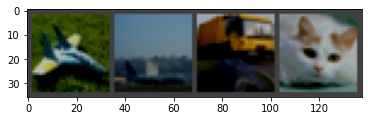

plane plane truck   cat


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    img = (img + 0.5) / 2
    npimg = img.numpy()
    # imshowでは(縦, 横, RGB)を期待されているが、npimgは(RGB, 縦, 横）となっている
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [12]:
import torch.nn as nn
import torch.nn.functional as F

- `nn.Module`クラスはbase
    - forwardなどが定義されているので、基本的にはこれを継承する

- `Conv2d(a, b, c)`
    - a: 入力のチャンネル数
    - b: 出力のチャンネル数
    - c: カーネルサイズ
   
- `MaxPool2d(a, b)`
    - a: カーネルサイズ
    - b: ストライド
   
---

画像のサイズの計算方法  
出力画像の縦を$O_h$、横を$O_w$とし、フィルタサイズを$F_h$、$F_w$とする。  
また、パディングを$P$、ストライドを$S$とすると
$$O_h = \frac{H + 2P - F_h}{S} + 1$$
$$O_w = \frac{W + 2P - F_w}{S} + 1$$

In [15]:
images[0].shape

torch.Size([3, 32, 32])

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # numpyのreshapeと同じ
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
net = Net()

## 3. Define a Loss function and optimizer

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [22]:
for epoch in tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 第二引数はなくても今回は同じeumerate(trainloader)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        # 勾配の初期化
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # パラメータの更新
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 1.880
[1,  4000] loss: 1.660
[1,  6000] loss: 1.571
[1,  8000] loss: 1.497
[1, 10000] loss: 1.440
[1, 12000] loss: 1.410


 50%|█████     | 1/2 [00:39<00:39, 39.84s/it]

[2,  2000] loss: 1.363
[2,  4000] loss: 1.324
[2,  6000] loss: 1.293
[2,  8000] loss: 1.285
[2, 10000] loss: 1.269
[2, 12000] loss: 1.239


100%|██████████| 2/2 [01:20<00:00, 40.42s/it]

Finished Training


モデルの保存

In [23]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

画像と真のラベル

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


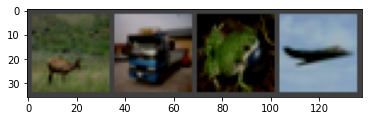

GroundTruth:   deer truck  frog plane


In [24]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

学習したモデルロード

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

予測

In [26]:
outputs = net(images)

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer   car  frog plane


テストデータ全てに対するAccuracy

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


クラスごとの正答率
- `with torch.no_grad()`
    - eval()の時でも勾配計算用のパラメータが自動で保存される??
    - これを行うことでパラメータの保存を止めることができ、メモリが溢れることを防げる

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 65 %
Accuracy of  bird : 26 %
Accuracy of   cat : 46 %
Accuracy of  deer : 33 %
Accuracy of   dog : 42 %
Accuracy of  frog : 74 %
Accuracy of horse : 62 %
Accuracy of  ship : 71 %
Accuracy of truck : 79 %
